In [1]:
import numpy as np
import hmmlearn.hmm as hmm
from dataclasses import dataclass
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


Model #0's score: -1728.1300608139456
Model #1's score: -1725.7402698753574
Model #2's score: -1725.2092413284438
Model #3's score: -1724.2248210071928
Model #4's score: -1725.952358134161
Model #5's score: -1726.4401610474858
Model #6's score: -1696.402444392227
Model #7's score: -1697.244841219009
Model #8's score: -1725.0108007929741
Model #9's score: -1724.54852914733
Model #10's score: -1725.0285995229042
Model #11's score: -1725.5292362340049
Model #12's score: -1724.852316615784
Model #13's score: -1724.7597130800586
Model #14's score: -1726.2836820403693
Model #15's score: -1726.144591701485
Model #16's score: -1725.4090359069817
Model #17's score: -1724.5790756799
Model #18's score: -1725.4652269580993
Model #19's score: -1723.318905303403


/var/folders/w6/n9ym2dfj19g5smxn2xlw8m980000gn/T/ipykernel_10316/1975393930.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(2, 2, figsize=(10, 5))


Model #20's score: -1725.1991335953571
Model #21's score: -1725.7972686667742
Model #22's score: -1704.3713117338914
Model #23's score: -1723.4851257600335
Model #24's score: -1726.4253447390051
Model #25's score: -1724.9083390948645
Model #26's score: -1726.3138220884373
Model #27's score: -1705.146311688965
Model #28's score: -1709.1716609773039
Model #29's score: -1713.9856552368321
Model #30's score: -1719.3984844536922
Model #31's score: -1700.3760610557397
Model #32's score: -1726.3207245531346
Model #33's score: -1725.4108729501927
Model #34's score: -1725.8518395295357
Model #35's score: -1724.8750964110643
Model #36's score: -1724.94002795524
Model #37's score: -1726.667677409711
Model #38's score: -1724.7112143895781
Model #39's score: -1696.9197297016765
Model #40's score: -1725.9097475613796
Model #41's score: -1710.2946021264343
Model #42's score: -1726.4736178397118
Model #43's score: -1702.1345326181406
Model #44's score: -1723.7507004410677
Model #45's score: -1696.5133

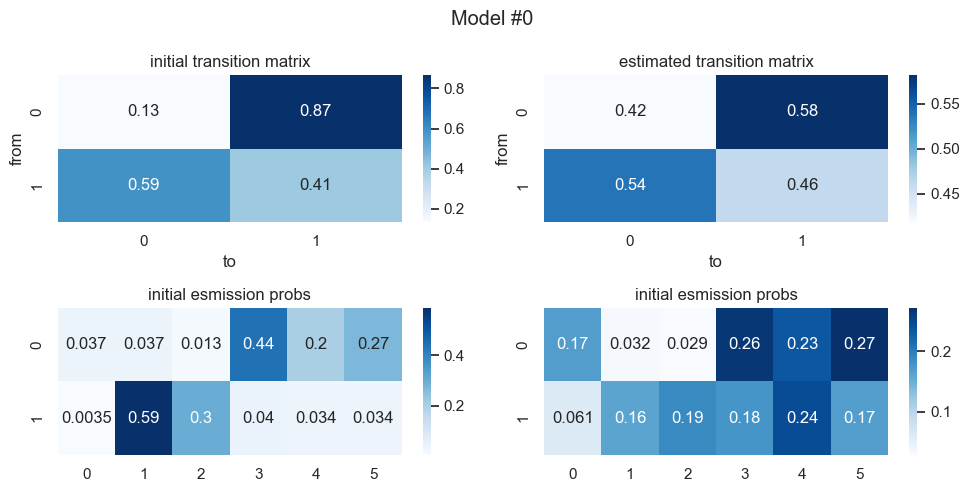

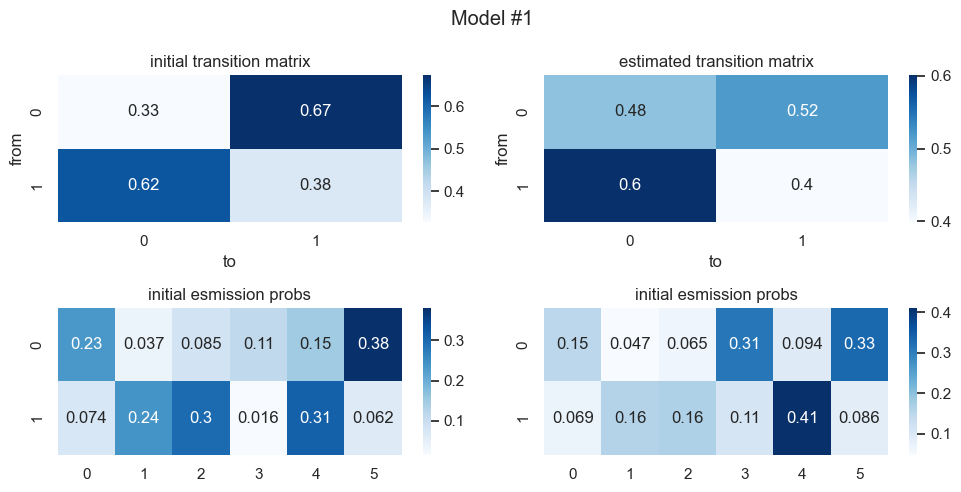

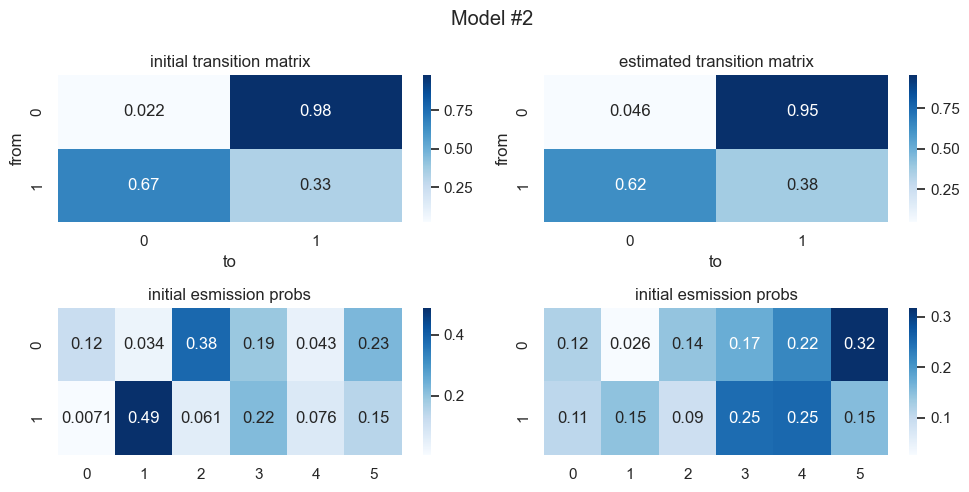

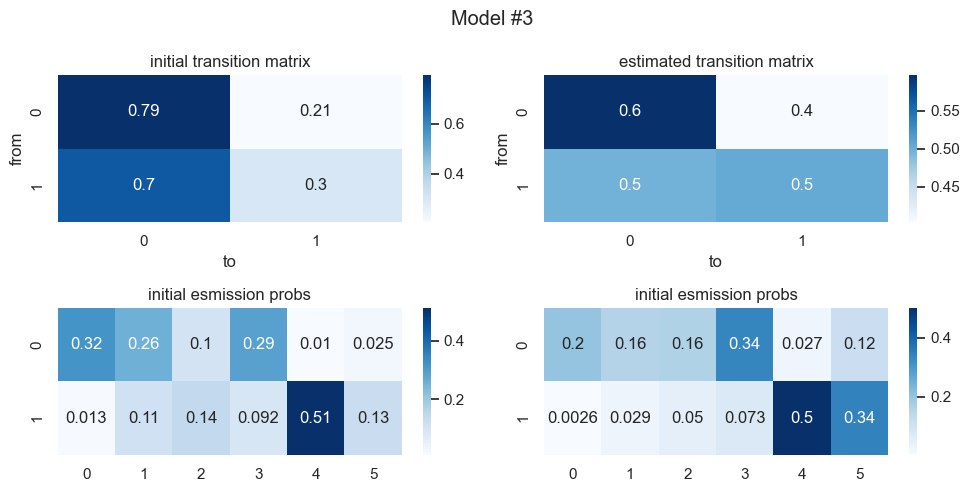

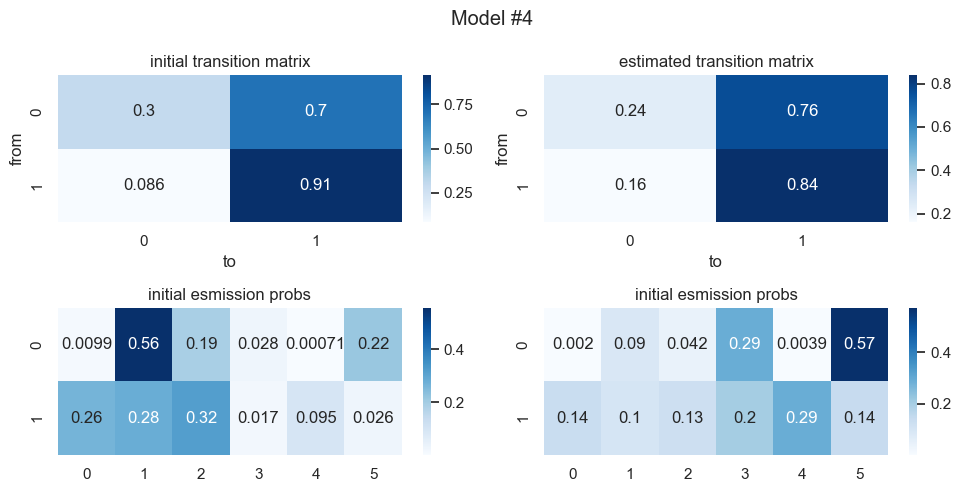

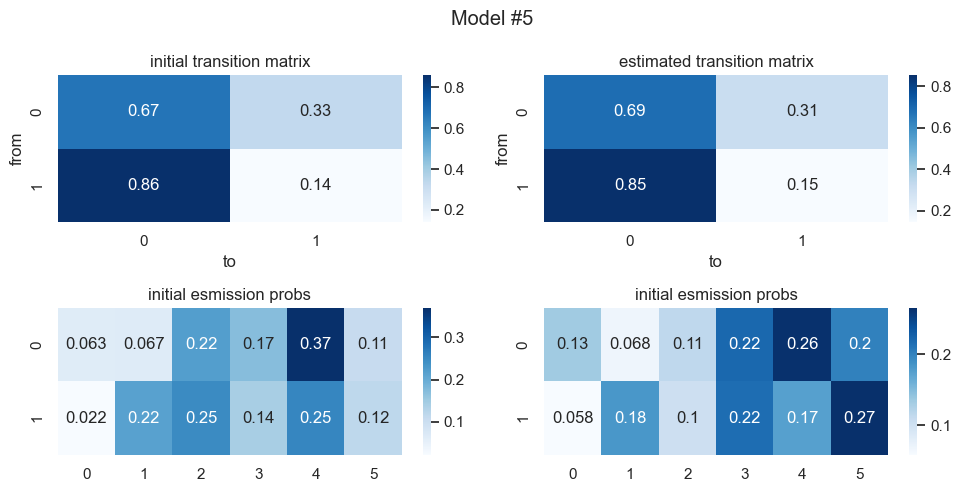

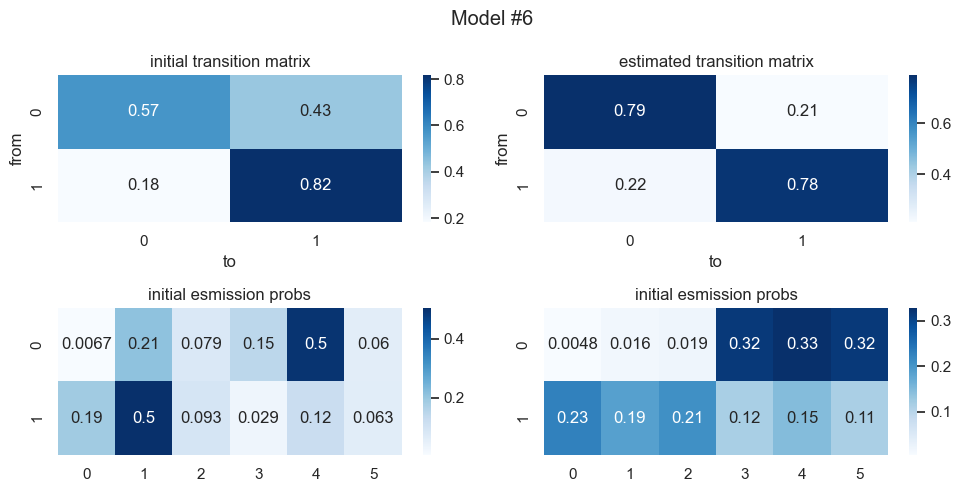

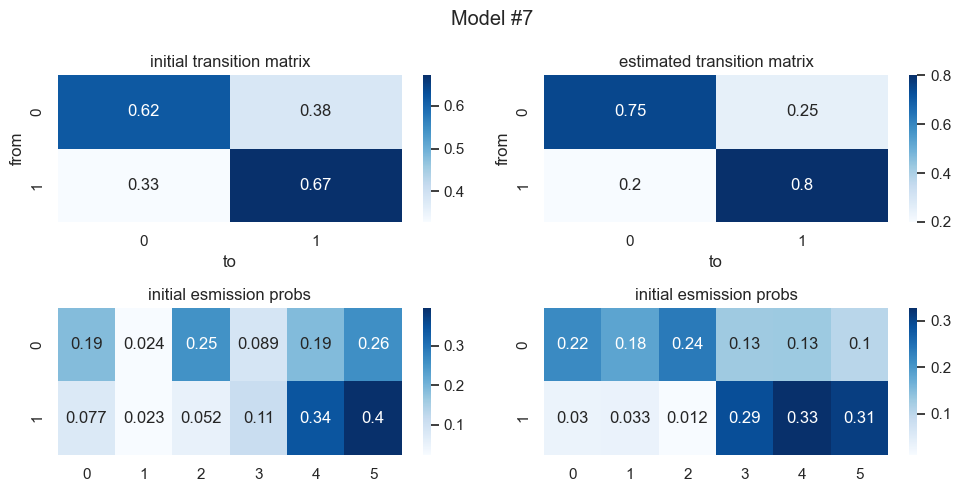

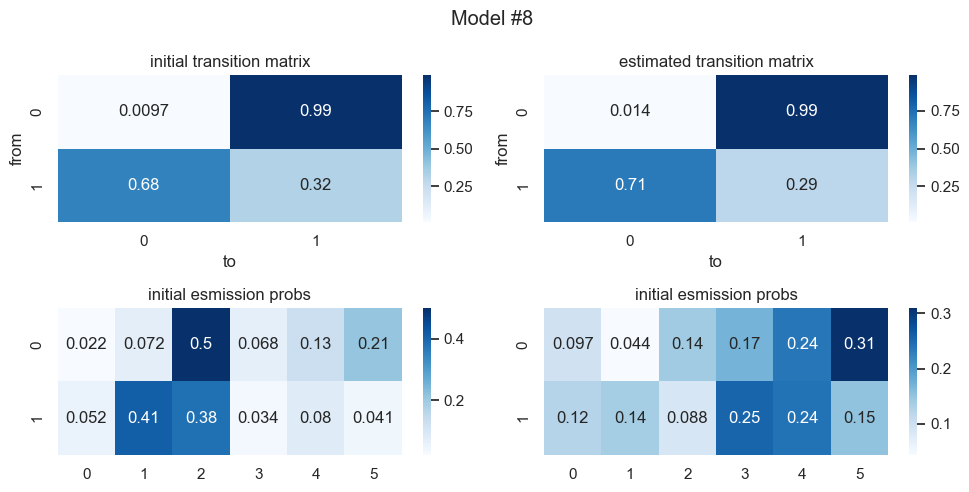

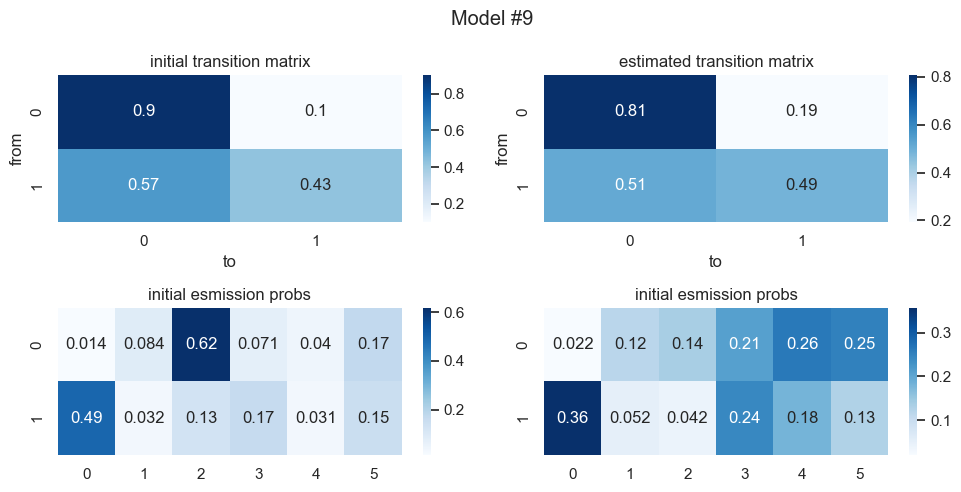

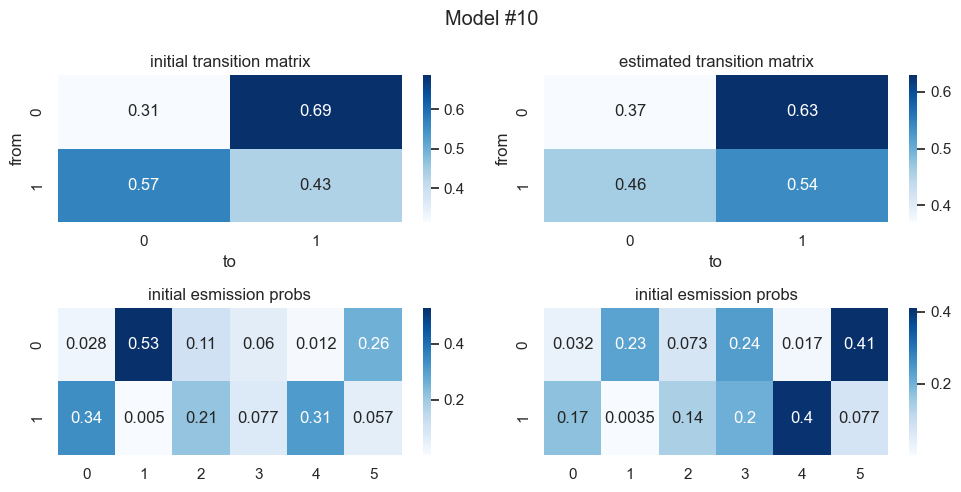

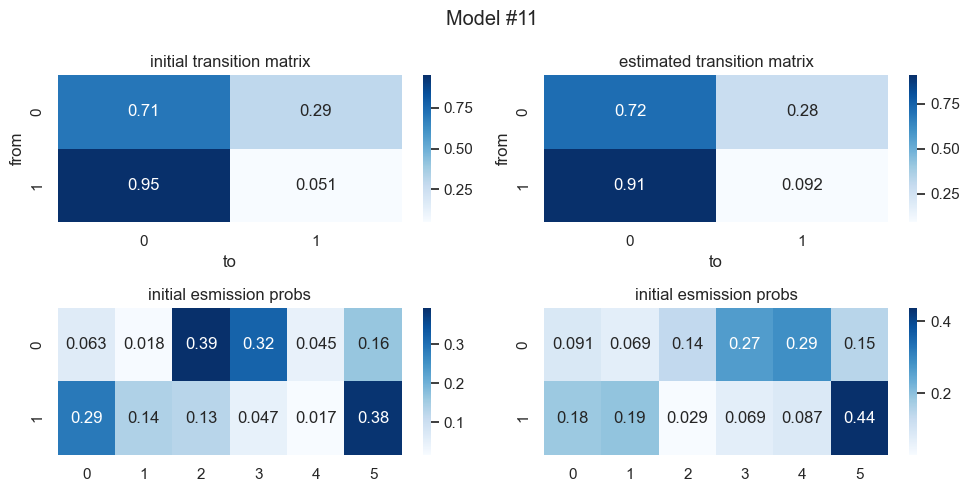

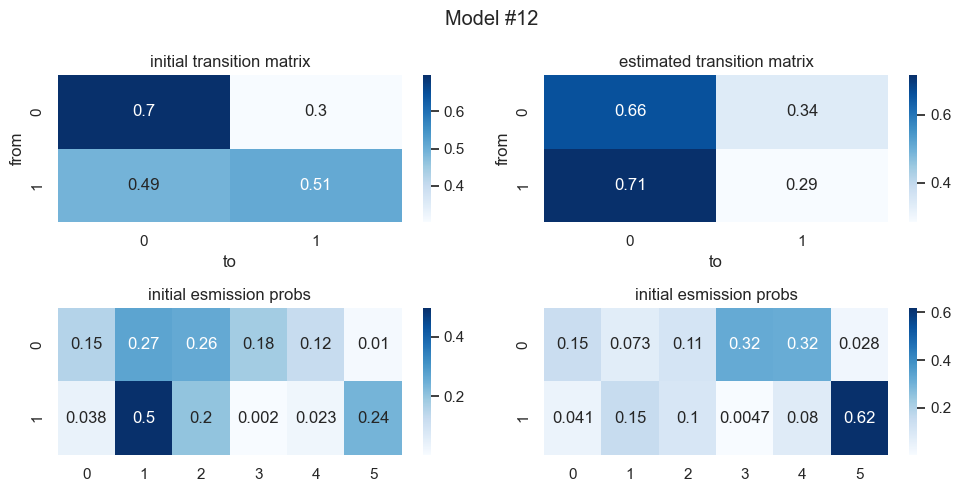

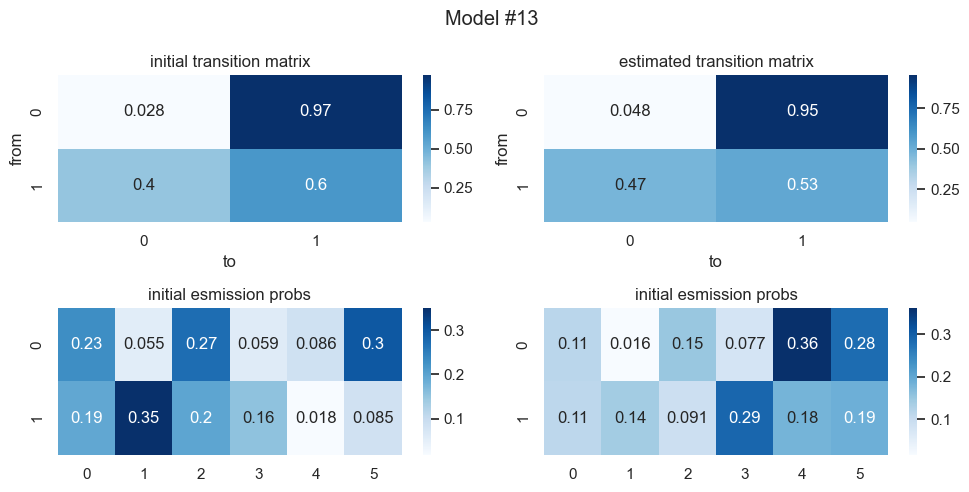

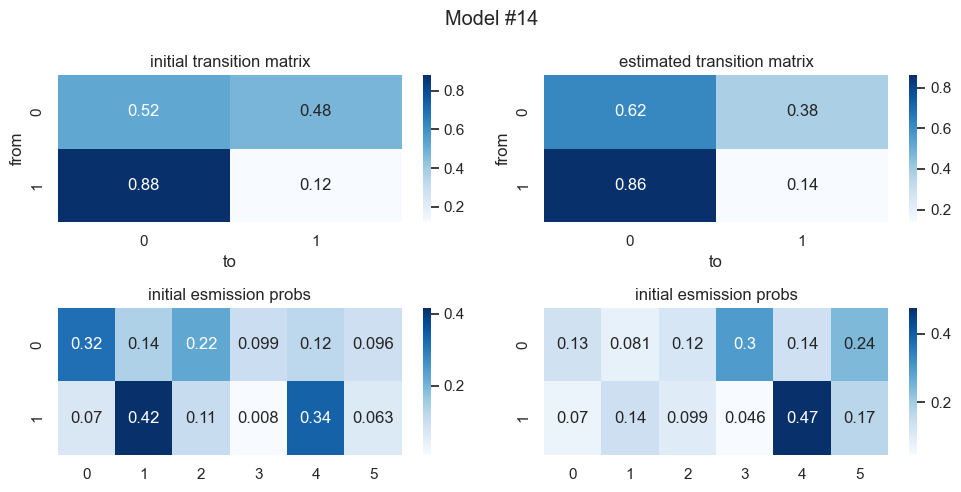

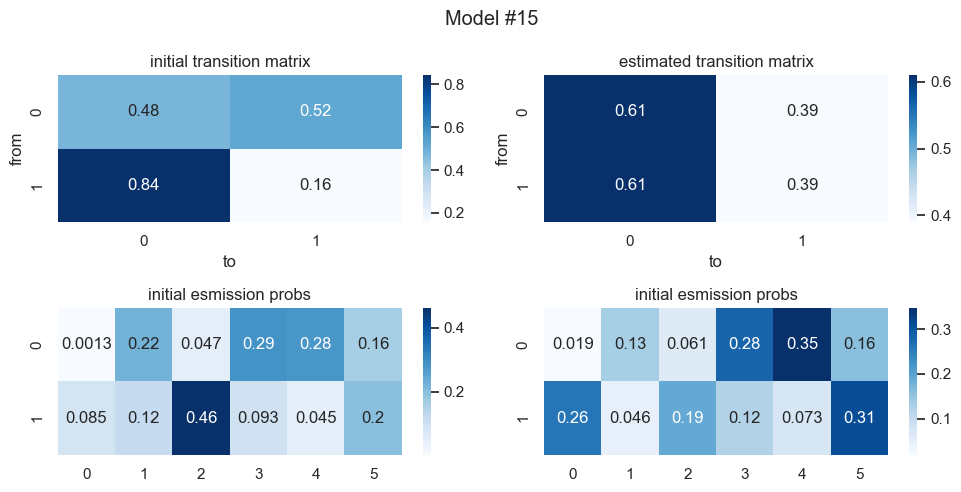

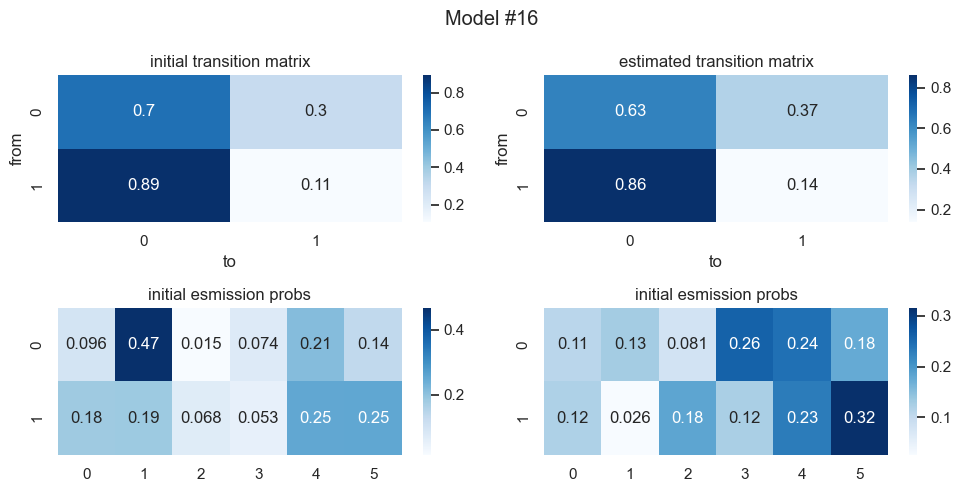

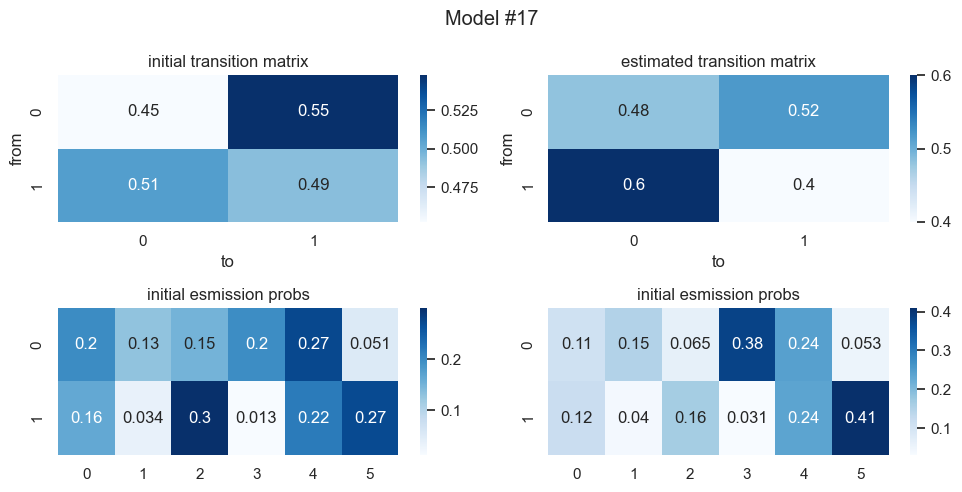

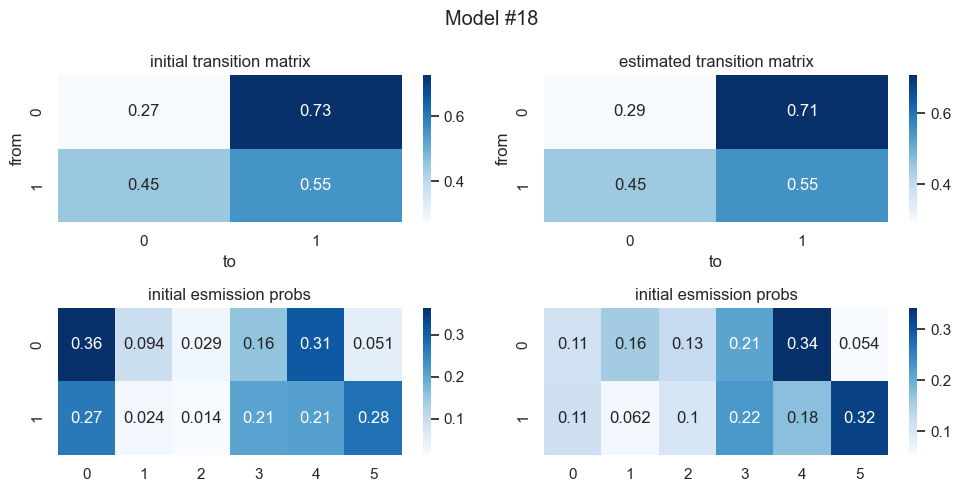

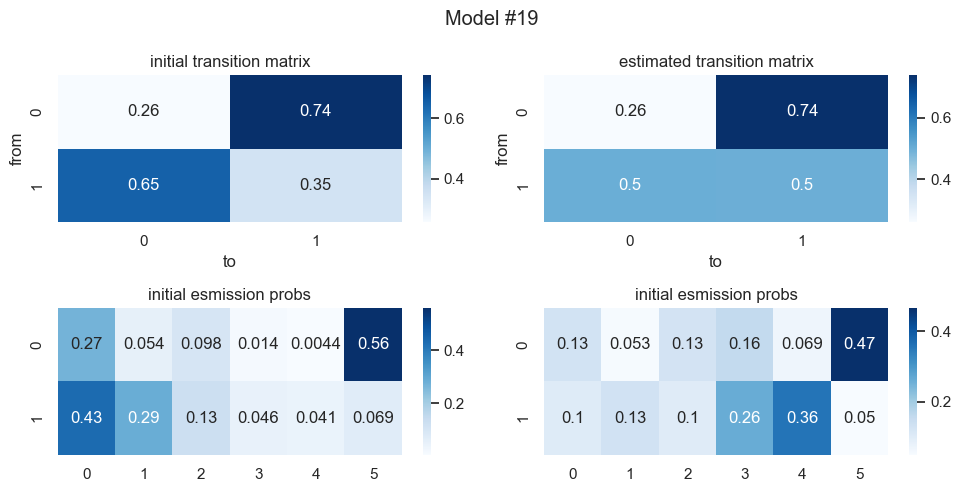

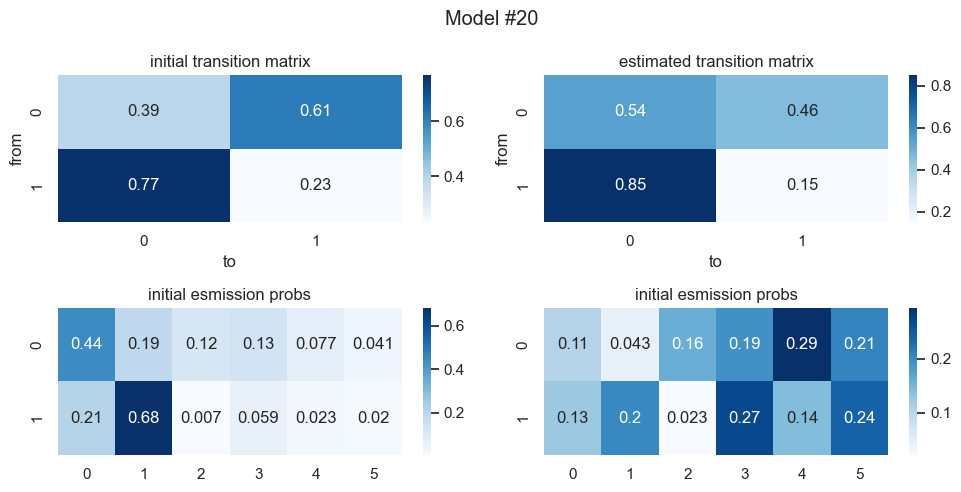

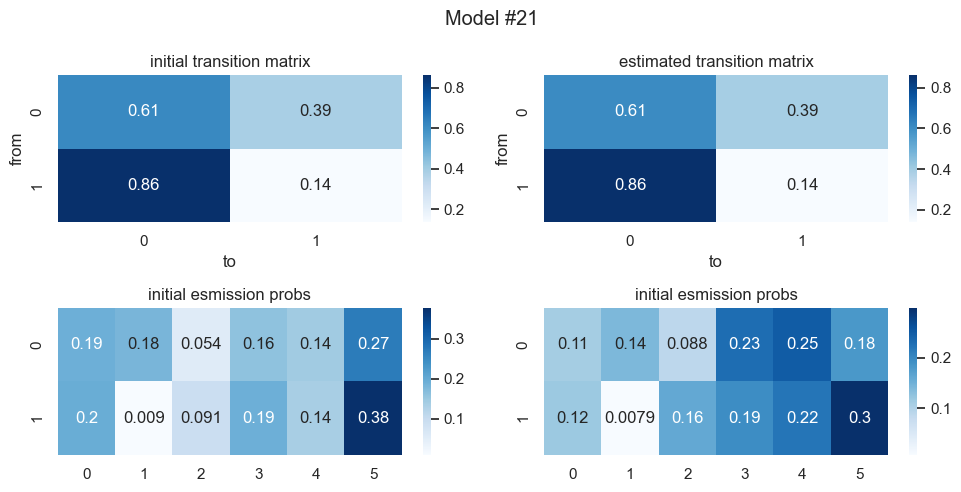

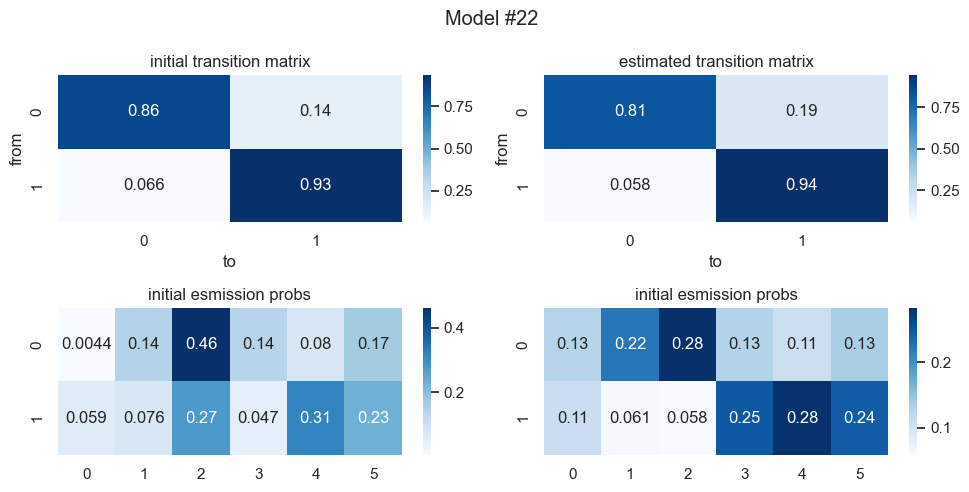

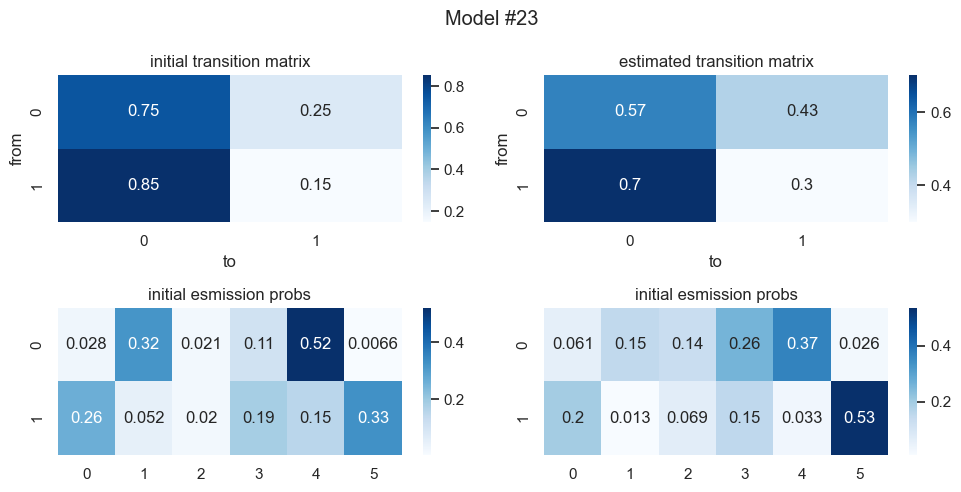

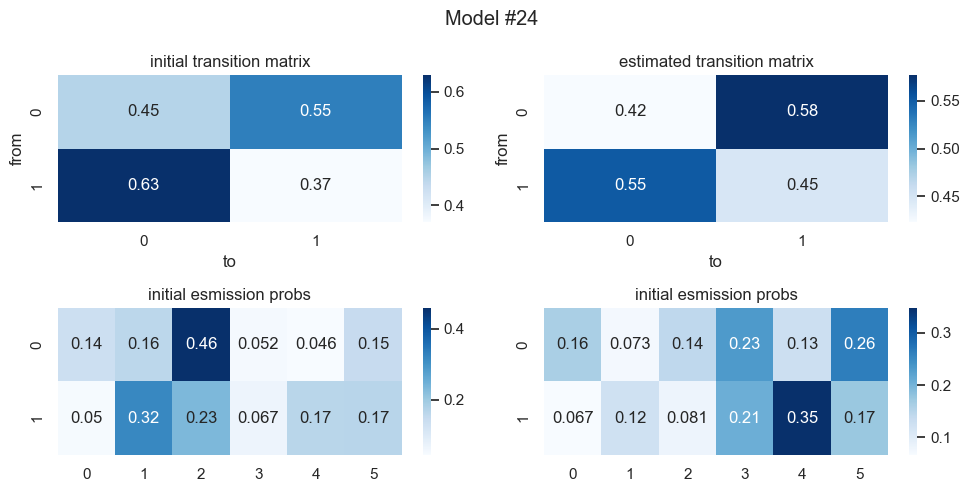

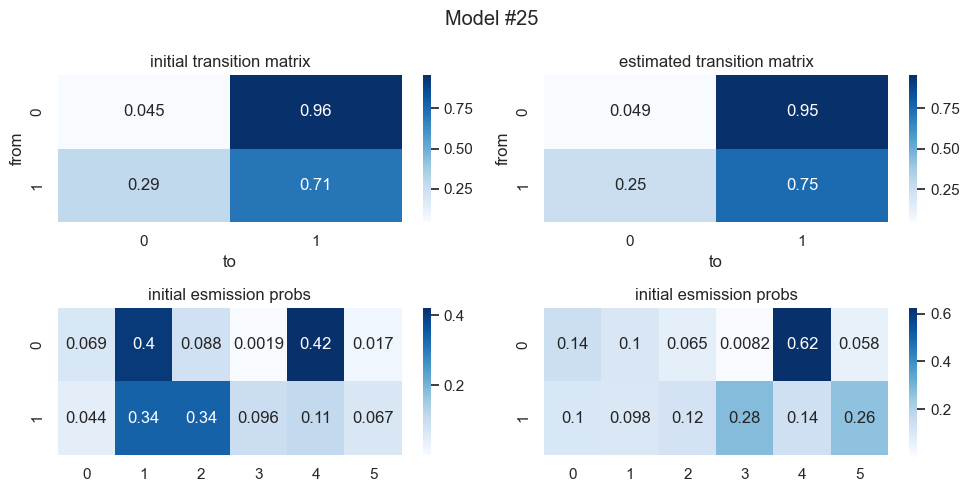

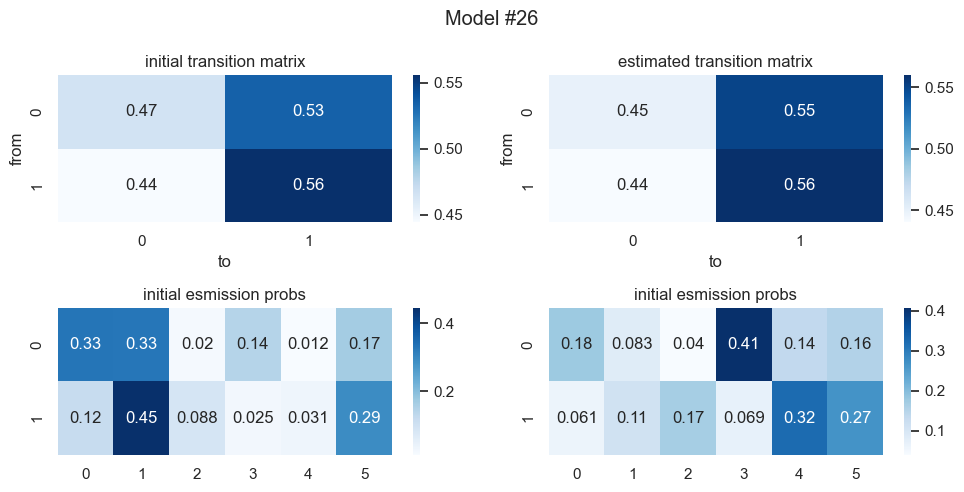

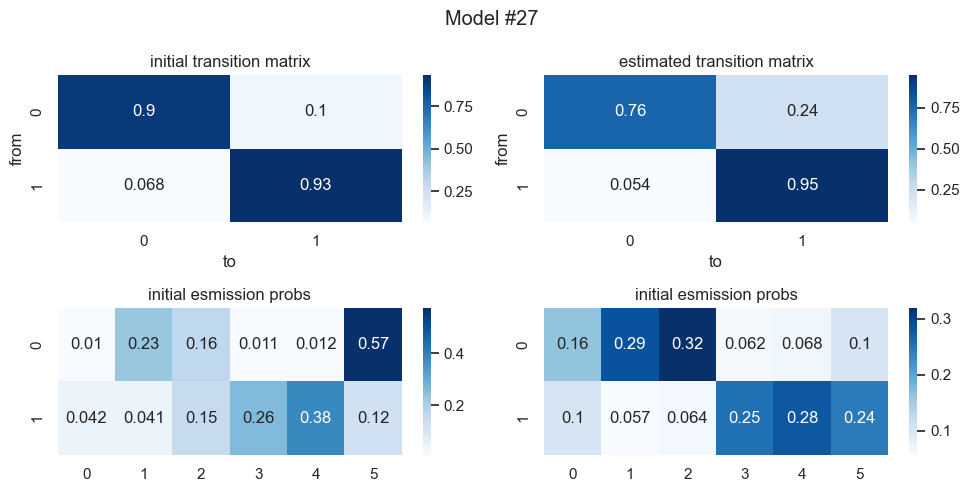

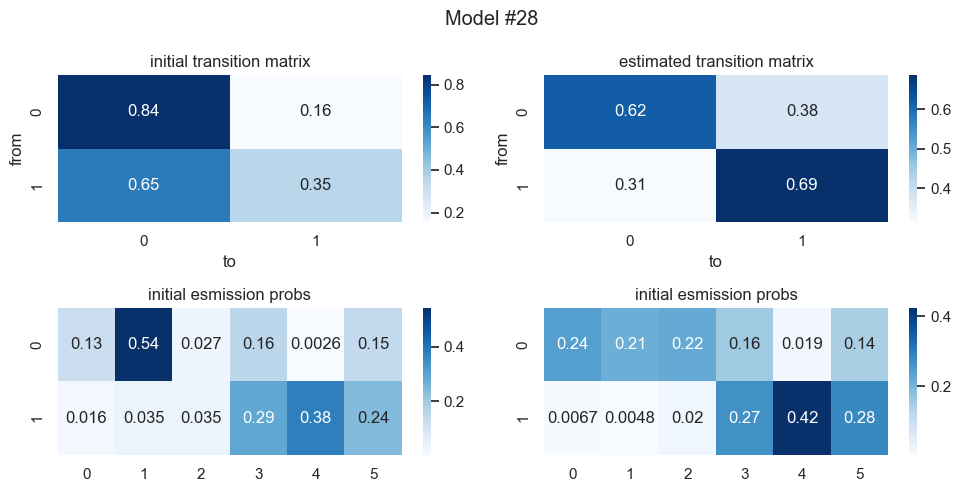

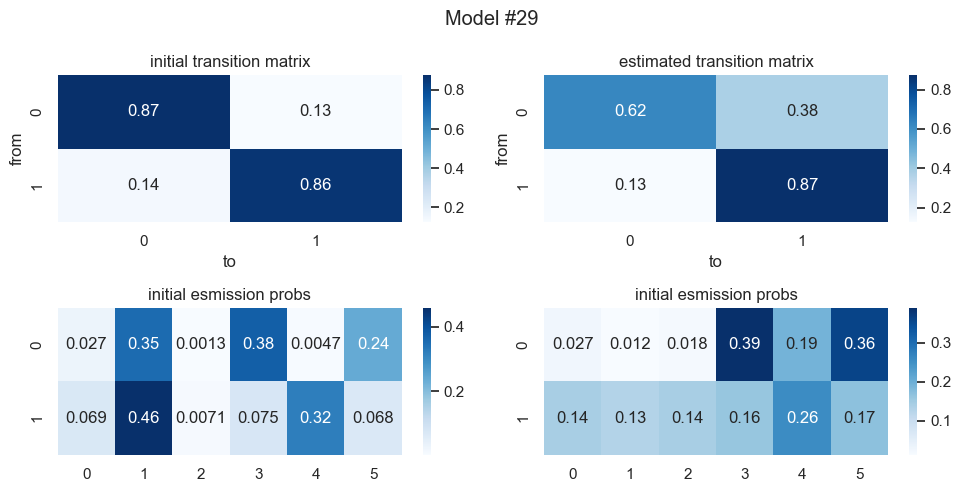

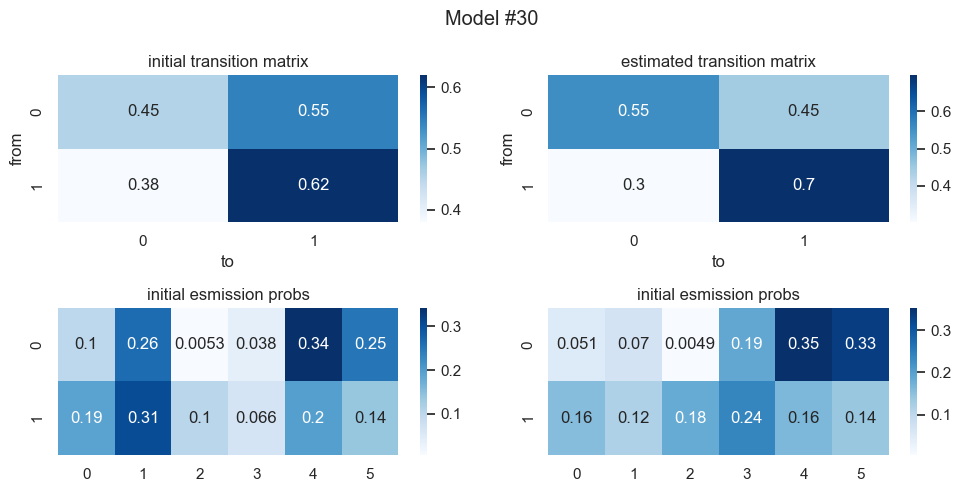

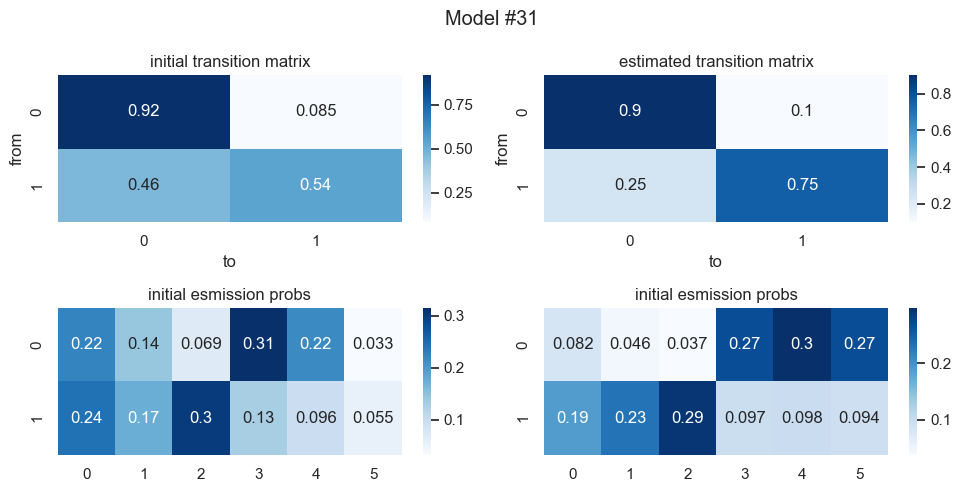

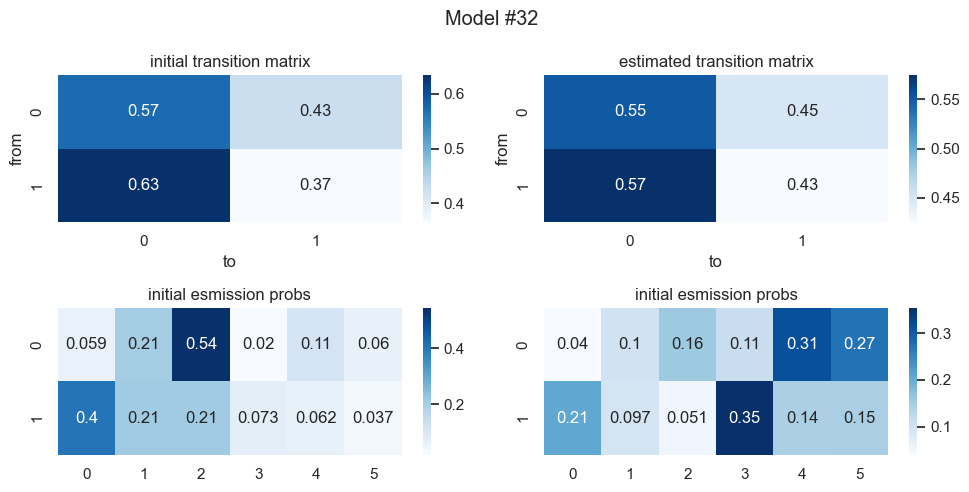

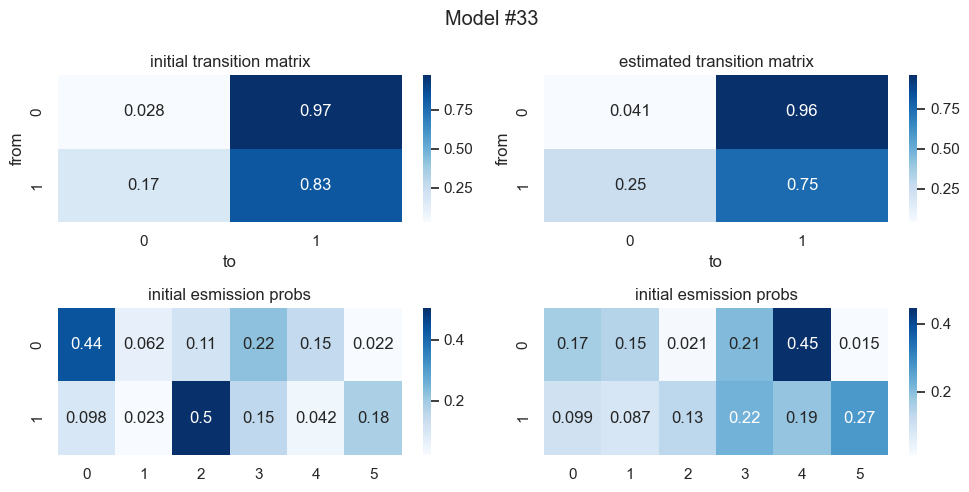

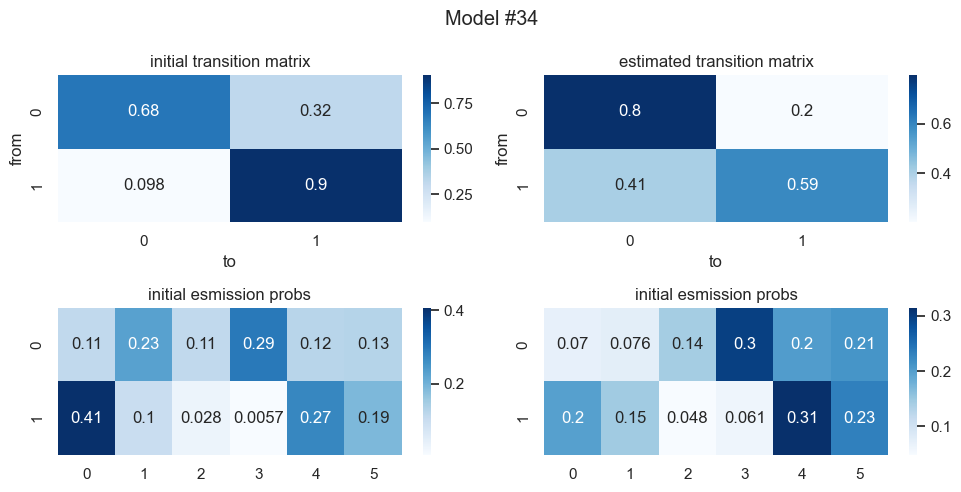

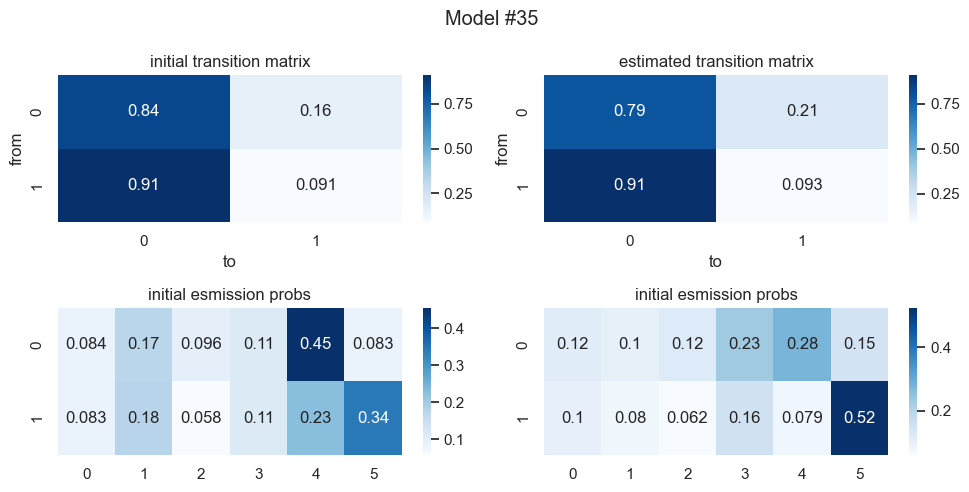

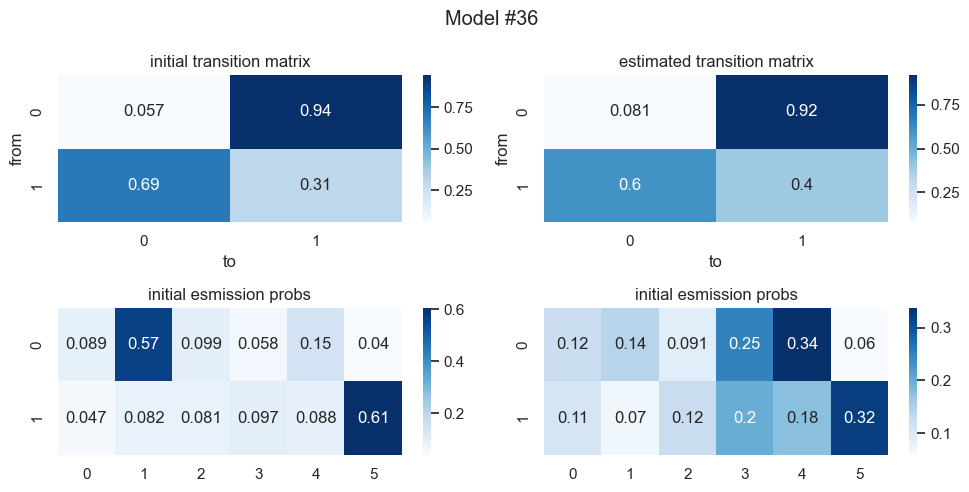

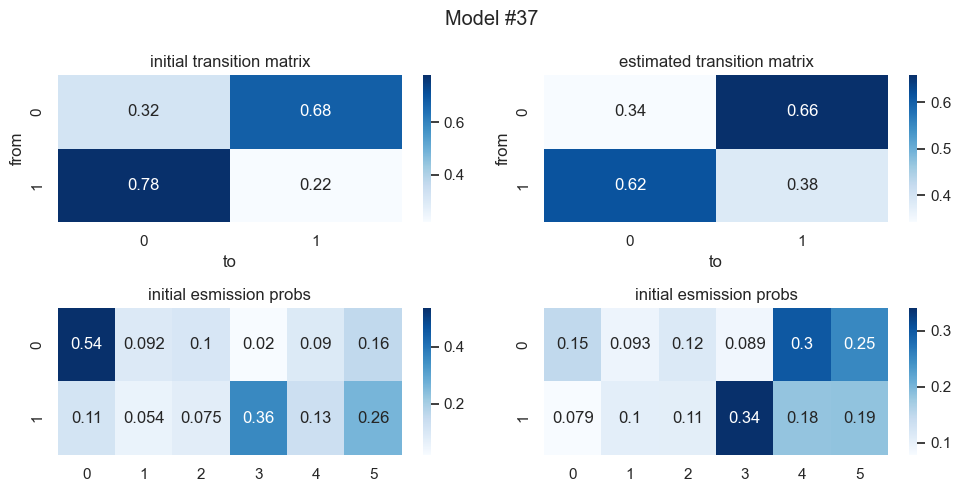

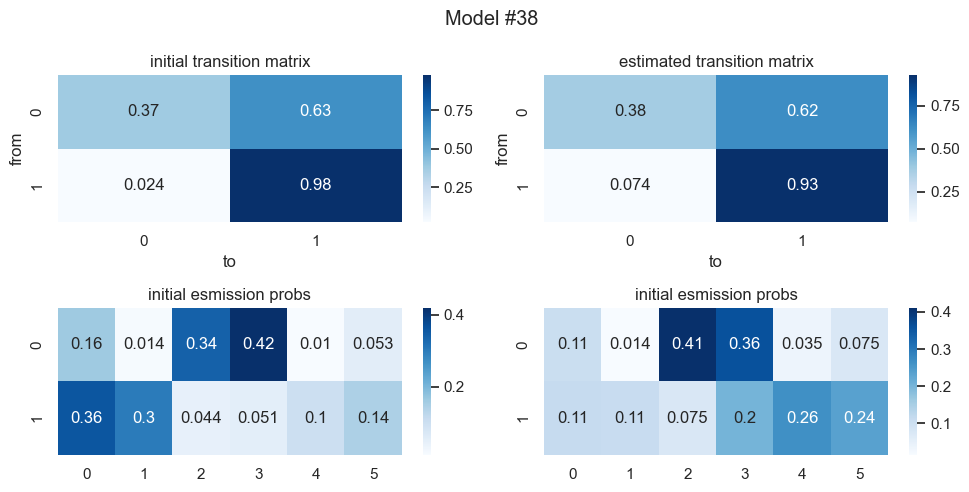

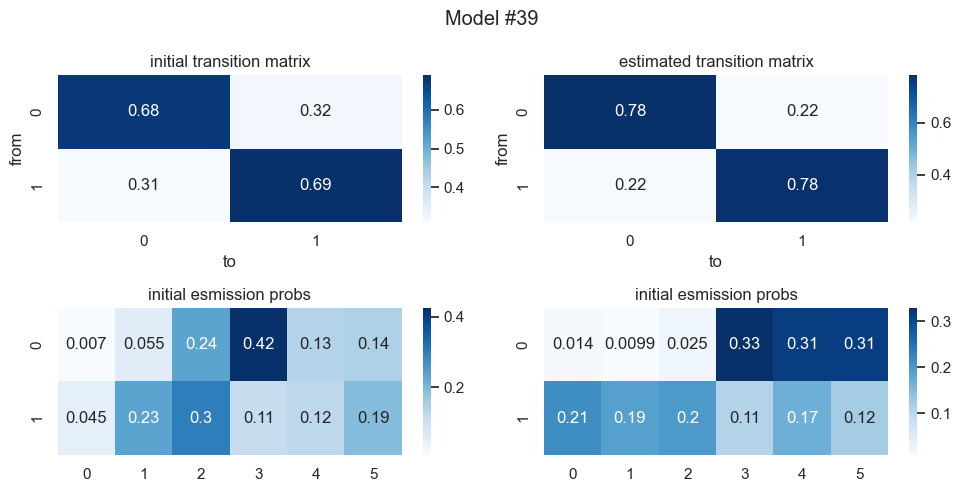

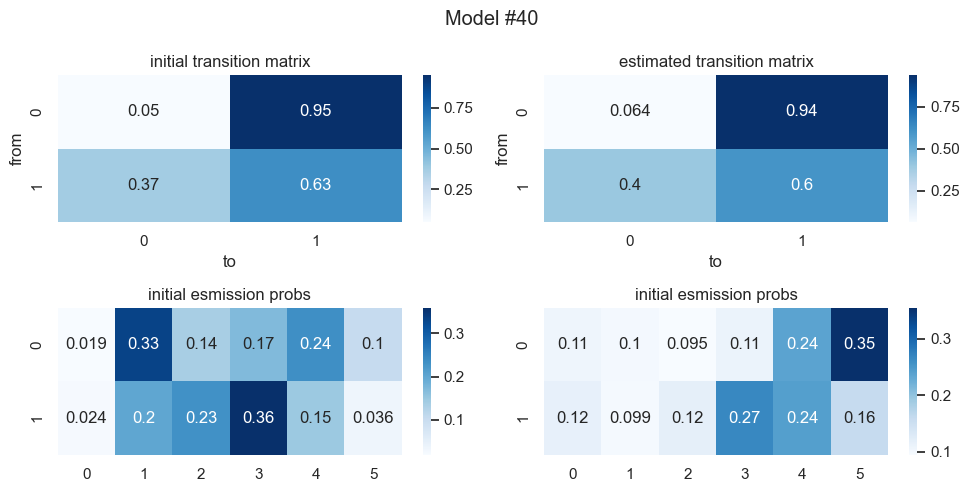

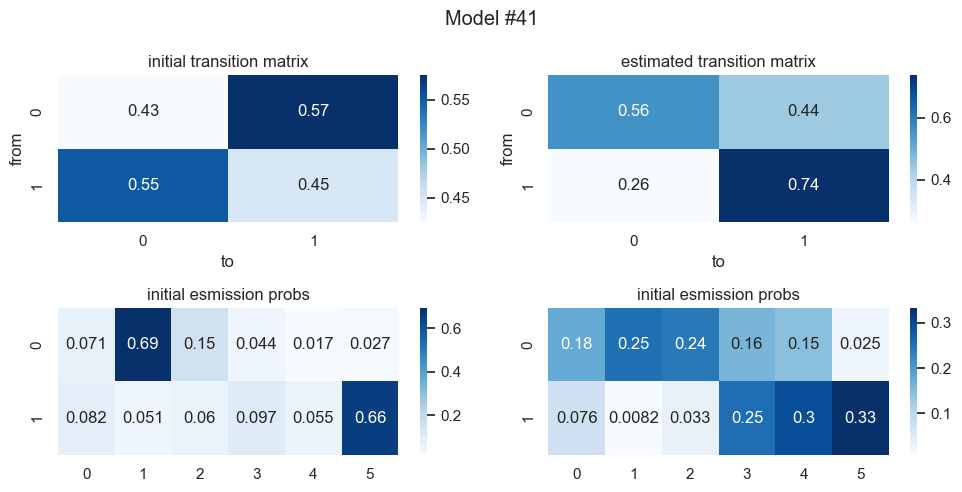

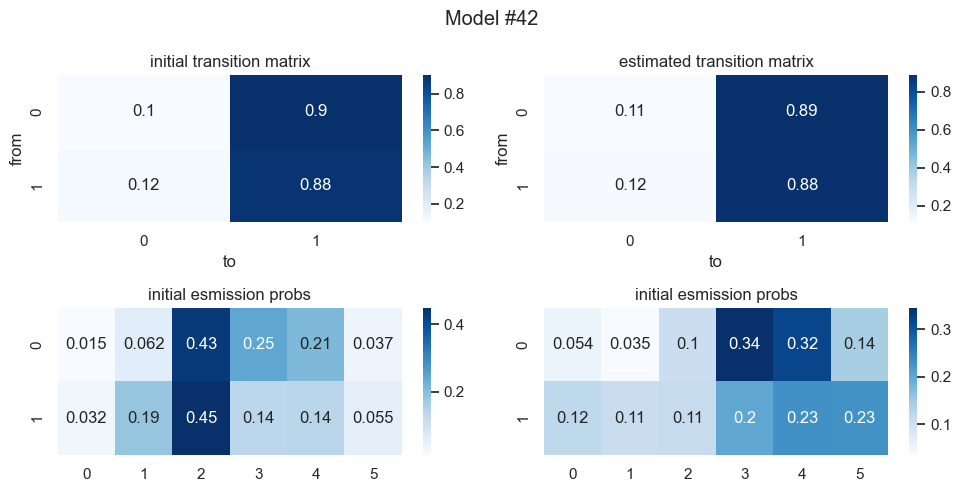

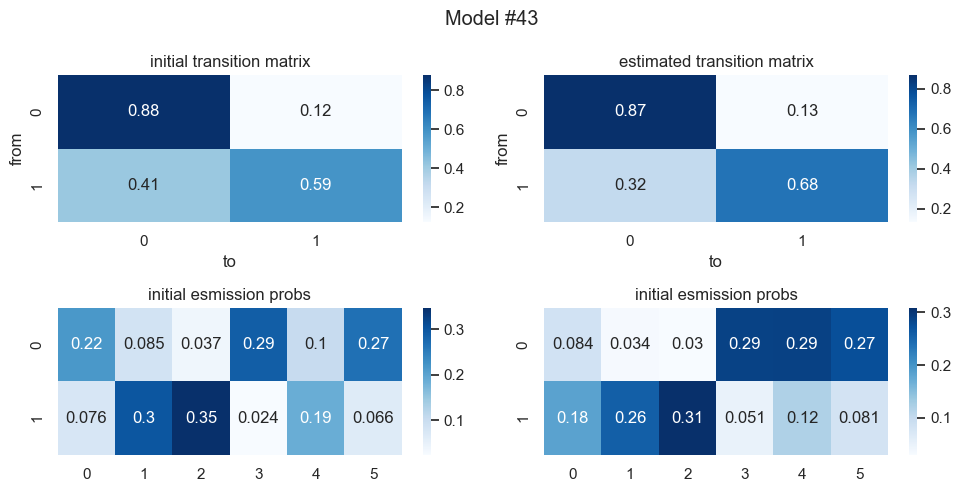

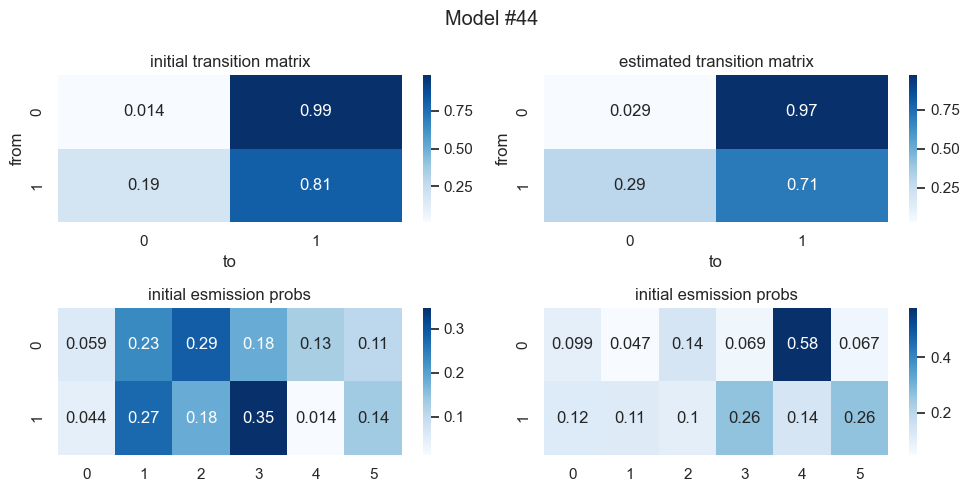

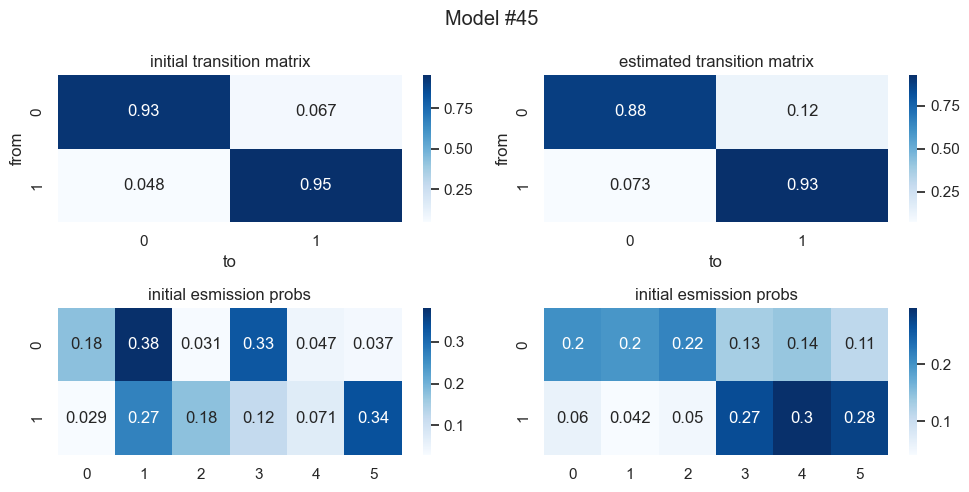

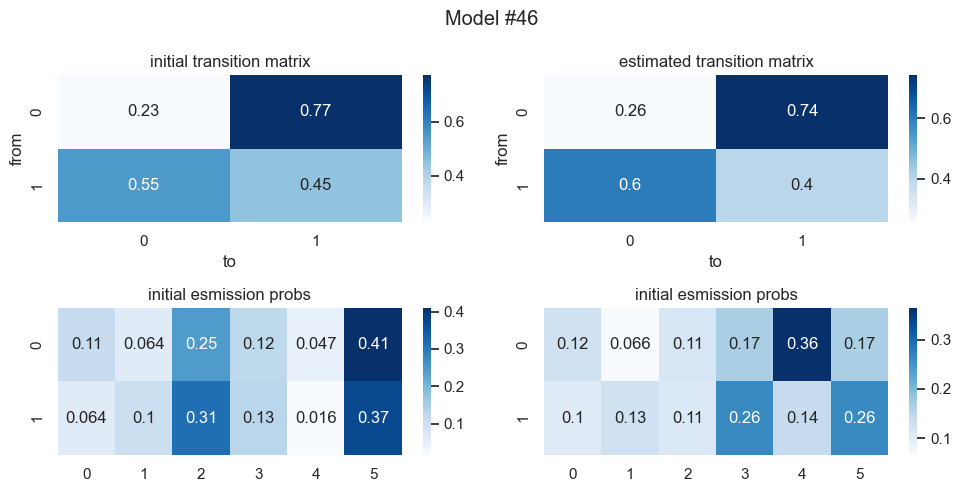

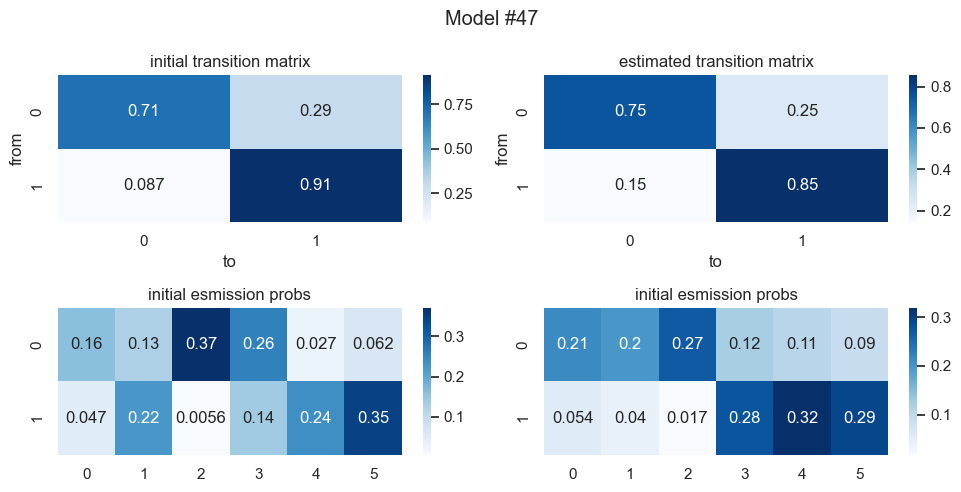

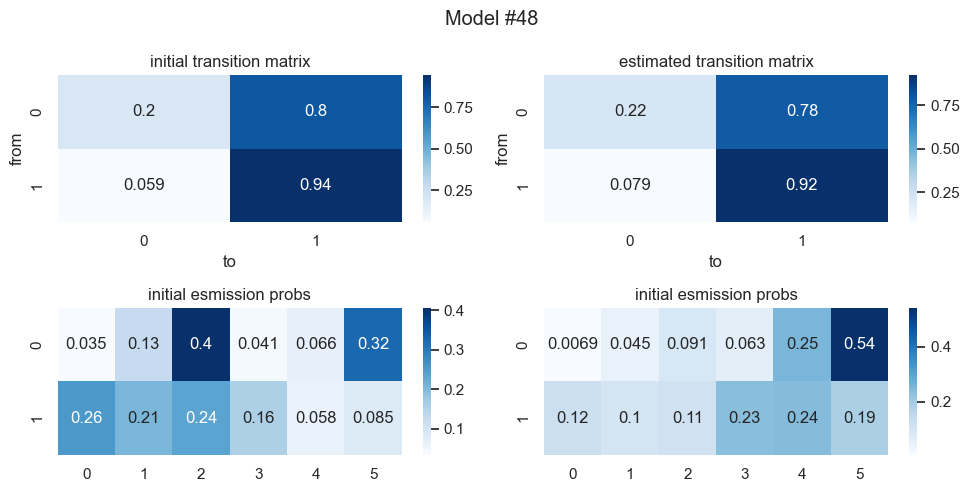

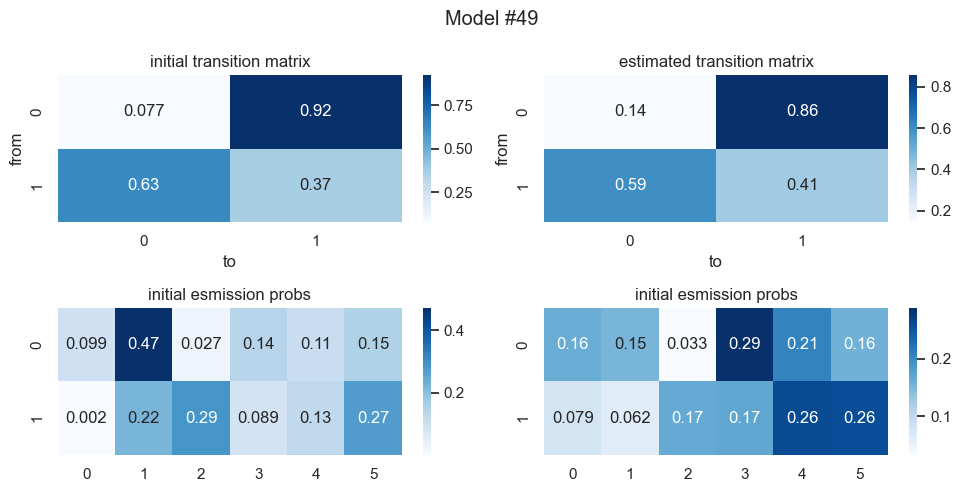

In [2]:
np.random.seed(42)

gen_model = hmm.CategoricalHMM(n_components=2, random_state=42)
gen_model.startprob_ = np.array([1.0, 0.0])
gen_model.transmat_ = np.array([[0.9, 0.1], [0.2, 0.8]])
gen_model.emissionprob_ = np.array([
        [1/6]*6,  # fair dice
        [0, 0, 0, 1/3, 1/3, 1/3]  # loaded dice
        ])

X, Z = gen_model.sample(1000)

gen_score = gen_model.score(X)

n_fits = 50
best_score = best_model = best_idx= None
for i in range(n_fits):
    model = hmm.CategoricalHMM(n_components=2, random_state=42, init_params="s")
    model.transmat_ = np.array([
        np.random.dirichlet([1, 1]), np.random.dirichlet([1, 1])
        ])
    model.emissionprob_ = np.array([
        np.random.dirichlet([1]*6), np.random.dirichlet([1]*6)
        ])
    initial_transmat = model.transmat_
    initial_esmissionprob = model.emissionprob_
    model.fit(X)
    estimated_transmat = model.transmat_
    estimated_esmissionprob = model.emissionprob_
    # plot
    fig, axs = plt.subplots(2, 2, figsize=(10, 5))
    axs = axs.flatten()
    sns.heatmap(initial_transmat, annot=True, cmap="Blues", ax=axs[0])
    axs[0].set_xlabel("to")
    axs[0].set_ylabel("from")
    axs[0].set_title("initial transition matrix")
    sns.heatmap(estimated_transmat, annot=True, cmap="Blues", ax=axs[1])
    axs[1].set_xlabel("to")
    axs[1].set_ylabel("from")
    axs[1].set_title("estimated transition matrix")
    sns.heatmap(initial_esmissionprob, annot=True, cmap="Blues", ax=axs[2])
    axs[2].set_title("initial esmission probs")
    sns.heatmap(estimated_esmissionprob, annot=True, cmap="Blues", ax=axs[3])
    axs[3].set_title("initial esmission probs")
    fig.suptitle(f"Model #{i}")
    fig.tight_layout()
    score = model.score(X)
    print(f"Model #{i}'s score: {score}")
    if best_score is None or score > best_score:
        best_model = model
        best_score = score
        best_idx = i

print(f'Generated score: {gen_score}\nBest score:      {best_score} (model #{best_idx})')


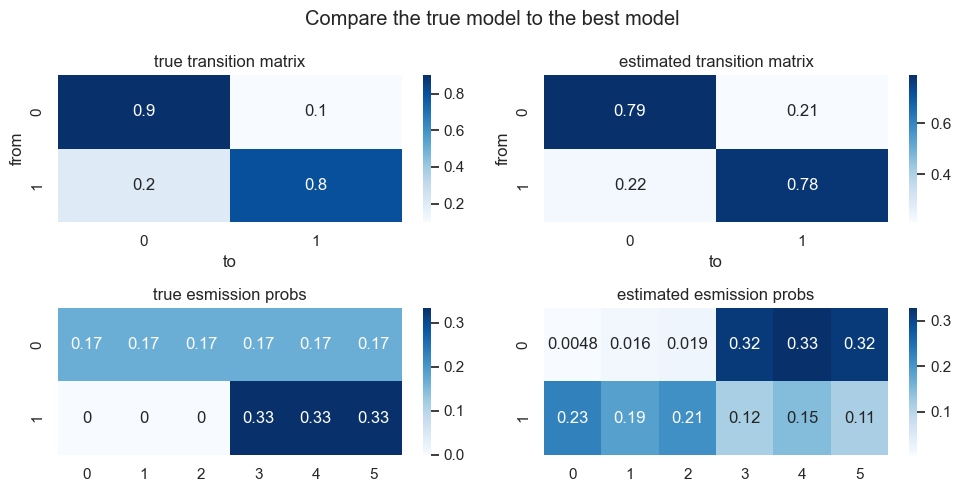

In [3]:
# compare best model to true model
fig, axs = plt.subplots(2, 2, figsize=(10, 5))
axs = axs.flatten()
sns.heatmap(gen_model.transmat_, annot=True, cmap="Blues", ax=axs[0])
axs[0].set_xlabel("to")
axs[0].set_ylabel("from")
axs[0].set_title("true transition matrix")
sns.heatmap(best_model.transmat_, annot=True, cmap="Blues", ax=axs[1])
axs[1].set_xlabel("to")
axs[1].set_ylabel("from")
axs[1].set_title("estimated transition matrix")
sns.heatmap(gen_model.emissionprob_, annot=True, cmap="Blues", ax=axs[2])
axs[2].set_title("true esmission probs")
sns.heatmap(best_model.emissionprob_, annot=True, cmap="Blues", ax=axs[3])
axs[3].set_title("estimated esmission probs")
fig.suptitle(f"Compare the true model to the best model")
fig.tight_layout()


stateが逆に出ているようなので, 反転させて比較する.  
- state 0: 通常サイコロ
- state 1: いかさまサイコロ

Text(0.5, 1.0, 'Confusion matrix')

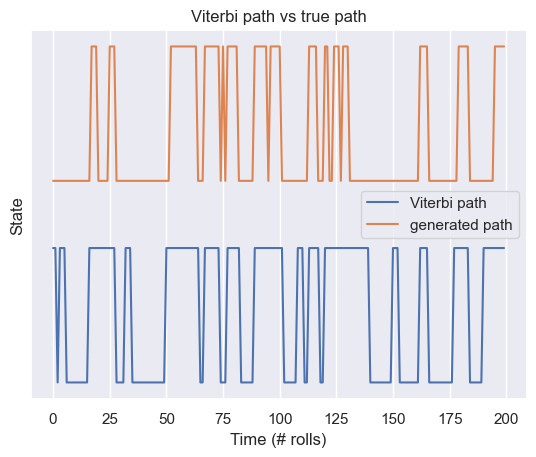

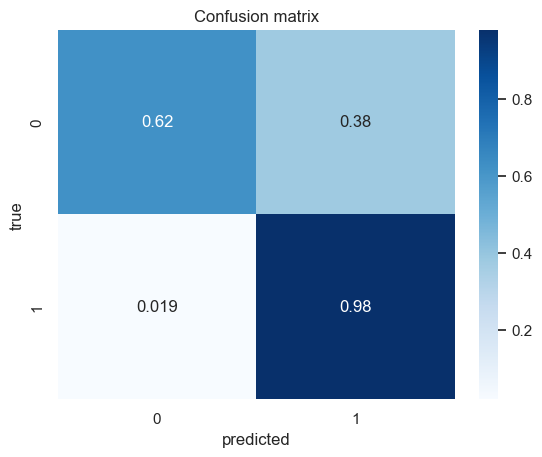

In [4]:
# best modelでViterbi pathを計算
viterbi_path = best_model.predict(X)

Z = Z.astype(bool)
viterbi_path = viterbi_path.astype(bool)

# plot our recovered states compared to generated (aim 1)
fig, ax = plt.subplots()
ax.plot(~viterbi_path[:200], label='Viterbi path')
ax.plot(Z[:200]+ 1.5, label='generated path')
ax.set_yticks([])
ax.set_title('Viterbi path vs true path')
ax.set_xlabel('Time (# rolls)')
ax.set_ylabel('State')
ax.legend()

from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(Z, ~viterbi_path, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, cmap="Blues", ax=ax)
ax.set_xlabel("predicted")
ax.set_ylabel("true")
ax.set_title("Confusion matrix")



- 本当にイカサマしてるときはだいたい見破れる
- ただしイカサマしてないときにもイカサマ指摘してしまうことが結構ある

Text(0.5, 1.0, 'Confusion matrix')

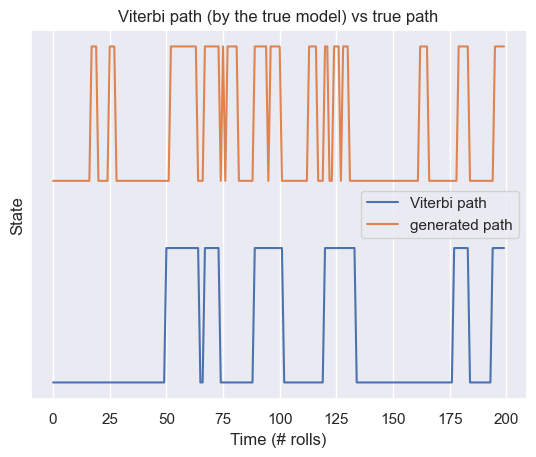

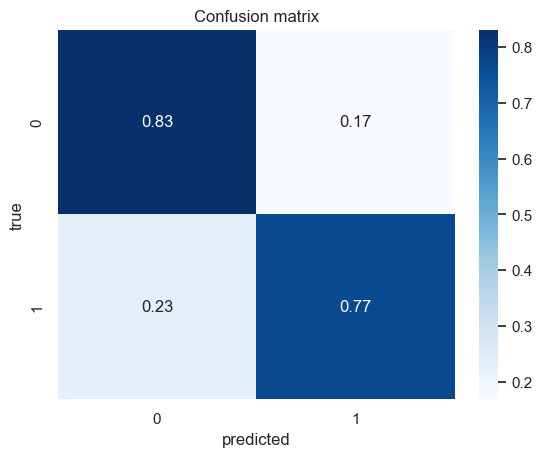

In [5]:
# true modelで計算したViterbi path
# best modelでViterbi pathを計算
viterbi_path = gen_model.predict(X)

Z = Z.astype(bool)
viterbi_path = viterbi_path.astype(bool)

# plot our recovered states compared to generated (aim 1)
fig, ax = plt.subplots()
ax.plot(viterbi_path[:200], label='Viterbi path')
ax.plot(Z[:200]+ 1.5, label='generated path')
ax.set_yticks([])
ax.set_title('Viterbi path (by the true model) vs true path')
ax.set_xlabel('Time (# rolls)')
ax.set_ylabel('State')
ax.legend()

from sklearn.metrics import confusion_matrix
confmat = confusion_matrix(Z, viterbi_path, normalize="true")
fig, ax = plt.subplots()
sns.heatmap(confmat, annot=True, cmap="Blues", ax=ax)
ax.set_xlabel("predicted")
ax.set_ylabel("true")
ax.set_title("Confusion matrix")
